In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# ------------------ 0. Konfigurasi ------------------
DATA_FILENAME = "breast+cancer+wisconsin+diagnostic\wdbc.data"   # DATASET
FEATURE_NAMES = [
    "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
    "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
    "radius_se","texture_se","perimeter_se","area_se","smoothness_se",
    "compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
    "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
    "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
]
N_TOTAL_EXPECTED = 569
N_TRAIN_VAL = 455
N_TEST = N_TOTAL_EXPECTED - N_TRAIN_VAL  # 114

In [4]:
# HyperPatameter PSO
SWARM_SIZE = 30
MAX_ITERS = 200          # SWARM_SIZE * MAX_ITERS = total fitness evals (<= max_evals)
MAX_EVALS = 100000
W_INERTIA = 0.72
C1 = 1.4
C2 = 1.4
POS_CLIP = (-20.0, 20.0)  # clamp weight values (optional)
VEL_CLIP = 5.0

# Regularization penalty in fitness (tie-breaker) -> penalize large norms
REG_PENALTY = 1e-4

In [5]:
# ------------------ 1. Load dataset ------------------
if not os.path.exists(DATA_FILENAME):
    raise FileNotFoundError(f"File '{DATA_FILENAME}' not found in current directory. Please download it from UCI and place it here.")

# wdbc.data format: id, diagnosis (M/B), 30 numeric features
df_raw = pd.read_csv(DATA_FILENAME, header=None)
# take first 32 columns (id, diagnosis, 30 features)
if df_raw.shape[1] < 32:
    raise ValueError(f"Unexpected file format: expected at least 32 columns, got {df_raw.shape[1]}")
df = df_raw.iloc[:, :32].copy()
cols = ["id","diagnosis"] + FEATURE_NAMES
df.columns = cols

# drop id
df = df.drop(columns=["id"])
# map diagnosis to numeric labels: B->0, M->1
df['label'] = df['diagnosis'].map({'B':0,'M':1}).astype(int)
df = df.drop(columns=['diagnosis'])

# quick sanity check
if len(df) != N_TOTAL_EXPECTED:
    print(f"Warning: file has {len(df)} rows (expected {N_TOTAL_EXPECTED}) — proceed anyway.")

In [6]:
# ------------------ 2. Stratified split train_val (455) / test (114) ------------------
def stratified_split(df, n_first, label_col='label', seed=RANDOM_SEED):
    df_shuf = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    counts = df_shuf[label_col].value_counts().to_dict()
    total = len(df_shuf)
    allocation = {}
    for cls, cnt in counts.items():
        allocation[cls] = int(round(cnt * (n_first / total)))
    # fix rounding
    allocated = sum(allocation.values())
    diff = n_first - allocated
    if diff != 0:
        remainders = {cls: (counts[cls]*(n_first/total) - allocation[cls]) for cls in allocation}
        for cls in sorted(remainders, key=remainders.get, reverse=True)[:abs(diff)]:
            allocation[cls] += 1 if diff>0 else -1
    idx_first = []
    idx_second = []
    for cls, take in allocation.items():
        rows = df_shuf[df_shuf[label_col]==cls]
        idx_first += list(rows.index[:take])
        idx_second += list(rows.index[take:])
    first = df_shuf.loc[idx_first].reset_index(drop=True)
    second = df_shuf.loc[idx_second].reset_index(drop=True)
    return first, second

train_val_df, test_df = stratified_split(df, n_first=N_TRAIN_VAL)
assert len(train_val_df) == N_TRAIN_VAL and len(test_df) == N_TEST, "Stratified sizes mismatch"

print("Label distribution (whole):", df['label'].value_counts().to_dict())
print("Label distribution (train_val):", train_val_df['label'].value_counts().to_dict())
print("Label distribution (test):", test_df['label'].value_counts().to_dict())

# save csvs for submission
Path(".").mkdir(parents=True, exist_ok=True)
train_val_df.to_csv("train_val.data.csv", index=False)
test_df.to_csv("test.data.csv", index=False)
print("Saved train_val.data.csv and test.data.csv")


Label distribution (whole): {0: 357, 1: 212}
Label distribution (train_val): {0: 285, 1: 170}
Label distribution (test): {0: 72, 1: 42}
Saved train_val.data.csv and test.data.csv


In [7]:
# ------------------ 3. Standardize features using train_val stats ------------------
X_train_val = train_val_df[FEATURE_NAMES].values.astype(float)
y_train_val = train_val_df['label'].values.astype(int)
mean_vec = X_train_val.mean(axis=0)
std_vec = X_train_val.std(axis=0, ddof=0)
std_vec[std_vec==0] = 1.0

def standardize(X, mean=mean_vec, std=std_vec):
    return (X - mean) / std

X_train_val_std = standardize(X_train_val)
X_test = test_df[FEATURE_NAMES].values.astype(float)
X_test_std = standardize(X_test)
y_test = test_df['label'].values.astype(int)


In [8]:
# ------------------ 4. Split train_val -> train / val (80/20) stratified ------------------
def stratified_train_val_split(df, val_frac=0.2, label_col='label', seed=RANDOM_SEED):
    df_shuf = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    classes = df_shuf[label_col].unique()
    train_idx = []
    val_idx = []
    for c in classes:
        rows = df_shuf[df_shuf[label_col]==c]
        n_val = int(round(len(rows) * val_frac))
        val_idx += list(rows.index[:n_val])
        train_idx += list(rows.index[n_val:])
    train = df_shuf.loc[train_idx].reset_index(drop=True)
    val = df_shuf.loc[val_idx].reset_index(drop=True)
    return train, val

train_df, val_df = stratified_train_val_split(train_val_df, val_frac=0.2)
X_train = standardize(train_df[FEATURE_NAMES].values.astype(float))
y_train = train_df['label'].values.astype(int)
X_val = standardize(val_df[FEATURE_NAMES].values.astype(float))
y_val = val_df['label'].values.astype(int)

# convert labels for hinge-prediction {+1,-1}
y_train_svm = np.where(y_train==1, 1, -1)
y_val_svm = np.where(y_val==1, 1, -1)
y_test_svm = np.where(y_test==1, 1, -1)
y_train_val_svm = np.where(y_train_val==1, 1, -1) if 'y_train_val' in locals() else np.where(y_train_val==1,1,-1) if False else None


In [9]:
# ------------------ 5. Utility metrics ------------------
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2*precision*recall / (precision+recall) if (precision+recall) > 0 else 0.0
    return precision, recall, f1

In [10]:
# ------------------ 6. SVM prediction helper (linear) ------------------
def svm_scores_from_params(param_vec, X):
    # param_vec: [w0..w29, b]
    w = param_vec[:-1]
    b = param_vec[-1]
    scores = np.dot(X, w) + b
    return scores

def svm_predict_from_params(param_vec, X):
    scores = svm_scores_from_params(param_vec, X)
    preds = np.where(scores >= 0, 1, -1)
    return preds

In [11]:
# ------------------ 7. Fitness function for PSO ------------------
# We'll maximize validation accuracy. Add small regularization penalty to prefer smaller norms on ties.
def make_cv_fitness(X, y, k=5, reg_penalty=REG_PENALTY):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

    def fitness(param_vec):
        accuracies = []
        w = param_vec[:-1]

        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            preds = svm_predict_from_params(param_vec, X_val)
            acc = np.mean(preds == y_val)
            accuracies.append(acc)

        mean_acc = np.mean(accuracies)
        # simpan agar bisa dianalisis nanti
        fitness.last_cv_acc = mean_acc

        penalty = reg_penalty * (np.linalg.norm(w)**2)
        return mean_acc - penalty

    fitness.last_cv_acc = None
    return fitness

fitness = make_cv_fitness(X_train_val_std, y_train_val_svm, k=5)

In [12]:
# ------------------ 8. Continuous PSO implementation ------------------
class ContinuousPSO:
    def __init__(self, n_dim, fitness_func, swarm_size=30, max_iters=100, w=0.72, c1=1.4, c2=1.4,
                 vel_clip=None, pos_clip=None, max_evals=100000, seed=RANDOM_SEED):
        self.n_dim = n_dim
        self.fitness_func = fitness_func
        self.swarm_size = swarm_size
        self.max_iters = max_iters
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.vel_clip = vel_clip
        self.pos_clip = pos_clip
        self.max_evals = max_evals
        self.seed = seed

        np.random.seed(self.seed)
        # init positions small gaussian, velocities small gaussian
        self.pos = np.random.normal(loc=0.0, scale=0.5, size=(swarm_size, n_dim))
        self.vel = np.random.normal(loc=0.0, scale=0.1, size=(swarm_size, n_dim))

        self.pbest_pos = self.pos.copy()
        self.pbest_fit = np.full(swarm_size, -np.inf)

        self.gbest_pos = None
        self.gbest_fit = -np.inf

        self.eval_count = 0
        self.history = []

    def step(self):
        # evaluate each particle
        for i in range(self.swarm_size):
            if self.eval_count >= self.max_evals:
                return False
            fit = self.fitness_func(self.pos[i])
            self.eval_count += 1
            if fit > self.pbest_fit[i]:
                self.pbest_fit[i] = fit
                self.pbest_pos[i] = self.pos[i].copy()
            if fit > self.gbest_fit:
                self.gbest_fit = fit
                self.gbest_pos = self.pos[i].copy()
        # update velocities & positions
        for i in range(self.swarm_size):
            r1 = np.random.rand(self.n_dim)
            r2 = np.random.rand(self.n_dim)
            cognitive = self.c1 * r1 * (self.pbest_pos[i] - self.pos[i])
            social = self.c2 * r2 * (self.gbest_pos - self.pos[i])
            self.vel[i] = self.w * self.vel[i] + cognitive + social
            if self.vel_clip is not None:
                self.vel[i] = np.clip(self.vel[i], -self.vel_clip, self.vel_clip)
            self.pos[i] = self.pos[i] + self.vel[i]
            if self.pos_clip is not None:
                self.pos[i] = np.clip(self.pos[i], self.pos_clip[0], self.pos_clip[1])
        return True

    def run(self, verbose=True):
        it = 0
        while it < self.max_iters and self.eval_count < self.max_evals:
            cont = self.step()
            if not cont:
                if verbose:
                    print("Reached max eval limit:", self.eval_count)
                break
            it += 1
            self.history.append((it, self.gbest_fit, self.eval_count))
            if verbose:
                print(f"Iter {it:03d} - best_val_acc={self.gbest_fit:.4f} evals={self.eval_count}")
        return self.gbest_pos, self.gbest_fit, self.history, self.eval_count


In [13]:
# ------------------ 9. Run PSO ------------------
n_features = X_train.shape[1]
n_dim = n_features + 1  # w dims + b
print("PSO optimizing vector dim:", n_dim)

pso = ContinuousPSO(n_dim=n_dim, fitness_func=fitness,
                    swarm_size=SWARM_SIZE, max_iters=MAX_ITERS,
                    w=W_INERTIA, c1=C1, c2=C2,
                    vel_clip=VEL_CLIP, pos_clip=POS_CLIP,
                    max_evals=MAX_EVALS, seed=RANDOM_SEED)

best_vec, best_fit, history, evals_used = pso.run(verbose=True)
print("PSO finished. Best validation fitness (acc - penalty):", best_fit)
print("Fitness evaluations used:", evals_used)

PSO optimizing vector dim: 31
Iter 001 - best_val_acc=0.8717 evals=30
Iter 002 - best_val_acc=0.9137 evals=60
Iter 003 - best_val_acc=0.9381 evals=90
Iter 004 - best_val_acc=0.9381 evals=120
Iter 005 - best_val_acc=0.9513 evals=150
Iter 006 - best_val_acc=0.9579 evals=180
Iter 007 - best_val_acc=0.9659 evals=210
Iter 008 - best_val_acc=0.9659 evals=240
Iter 009 - best_val_acc=0.9659 evals=270
Iter 010 - best_val_acc=0.9686 evals=300
Iter 011 - best_val_acc=0.9710 evals=330
Iter 012 - best_val_acc=0.9711 evals=360
Iter 013 - best_val_acc=0.9711 evals=390
Iter 014 - best_val_acc=0.9721 evals=420
Iter 015 - best_val_acc=0.9738 evals=450
Iter 016 - best_val_acc=0.9738 evals=480
Iter 017 - best_val_acc=0.9738 evals=510
Iter 018 - best_val_acc=0.9738 evals=540
Iter 019 - best_val_acc=0.9741 evals=570
Iter 020 - best_val_acc=0.9761 evals=600
Iter 021 - best_val_acc=0.9780 evals=630
Iter 022 - best_val_acc=0.9780 evals=660
Iter 023 - best_val_acc=0.9780 evals=690
Iter 024 - best_val_acc=0.9780

In [14]:
# Recompute mean CV accuracy for best vector (no penalty)
cv_acc_list = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for tr_idx, val_idx in skf.split(X_train_val_std, y_train_val_svm):
    preds_cv = svm_predict_from_params(best_vec, X_train_val_std[val_idx])
    acc_cv = np.mean(preds_cv == y_train_val_svm[val_idx])
    cv_acc_list.append(acc_cv)

acc_cv_best = np.mean(cv_acc_list)
print(f"5-Fold CV Accuracy (no penalty): {acc_cv_best:.4f}")


5-Fold CV Accuracy (no penalty): 0.9846


In [25]:
# ------------------ 10. Evaluate best vector on test ------------------
test_preds_svm = svm_predict_from_params(best_vec, X_test_std)
test_preds_binary = np.where(test_preds_svm==1, 1, 0)
test_y_binary = y_test

test_acc = accuracy(test_y_binary, test_preds_binary)
prec, rec, f1 = precision_recall_f1(test_y_binary, test_preds_binary)

print("\n--- Test set results ---")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Accuracy on full train_val (how model generalizes on train_val)
preds_train_val = svm_predict_from_params(best_vec, X_train_val_std)
preds_train_val_binary = np.where(preds_train_val==1, 1, 0)
acc_train_val = accuracy(y_train_val, preds_train_val_binary)
print(f"Accuracy on full train_val (455): {acc_train_val:.4f}")

cm = np.array([
    [np.sum((test_y_binary==0)&(test_preds_binary==0)), np.sum((test_y_binary==0)&(test_preds_binary==1))],
    [np.sum((test_y_binary==1)&(test_preds_binary==0)), np.sum((test_y_binary==1)&(test_preds_binary==1))]
])


--- Test set results ---
Test Accuracy: 0.9474
Precision: 0.9286, Recall: 0.9286, F1: 0.9286
Accuracy on full train_val (455): 0.9846


In [16]:
# ------------------ 11. Save artifacts ------------------
hist_df = pd.DataFrame(history, columns=["iter","best_val_fit","evals"])
hist_df.to_csv("pso_history.csv", index=False)
np.save("best_svm_params.npy", best_vec)
print("Saved pso_history.csv and best_svm_params.npy")

Saved pso_history.csv and best_svm_params.npy


Saved pso_convergence.png


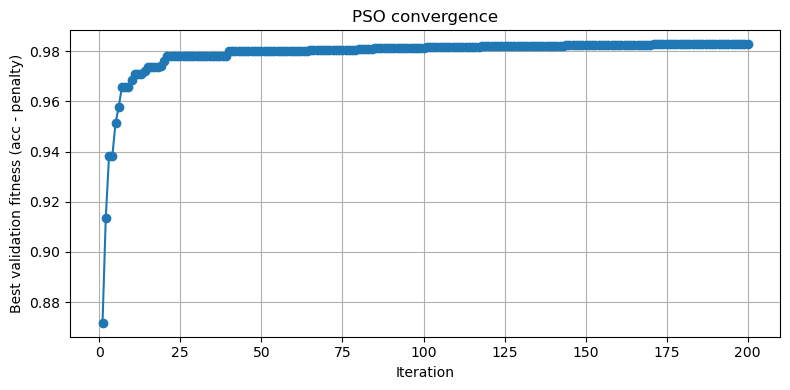

In [17]:
# ------------------ 12. Plot convergence ------------------
plt.figure(figsize=(8,4))
plt.plot(hist_df['iter'], hist_df['best_val_fit'], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best validation fitness (acc - penalty)")
plt.title("PSO convergence")
plt.grid(True)
plt.tight_layout()
plt.savefig("pso_convergence.png")
print("Saved pso_convergence.png")

In [18]:
# ------------------ 13. Overfitting analysis ------------------
print("\n--- Overfitting Analysis ---")
overfit_gap = acc_train_val - test_acc
cv_gap = acc_cv_best - test_acc

print(f"Train_val Accuracy : {acc_train_val:.4f}")
print(f"CV Accuracy        : {acc_cv_best:.4f}")
print(f"Test Accuracy      : {test_acc:.4f}")
print(f"Overfit Gap (Train_val - Test): {overfit_gap:.4f}")
print(f"CV Gap (CV - Test): {cv_gap:.4f}")

if cv_gap > 0.05:
    print("⚠ Model kemungkinan overfit (CV jauh lebih tinggi daripada Test).")
elif cv_gap < -0.05:
    print("⚠ Model kemungkinan underfit.")
else:
    print("✔ Model generalisasi cukup baik.")



--- Overfitting Analysis ---
Train_val Accuracy : 0.9846
CV Accuracy        : 0.9846
Test Accuracy      : 0.9474
Overfit Gap (Train_val - Test): 0.0372
CV Gap (CV - Test): 0.0372
✔ Model generalisasi cukup baik.


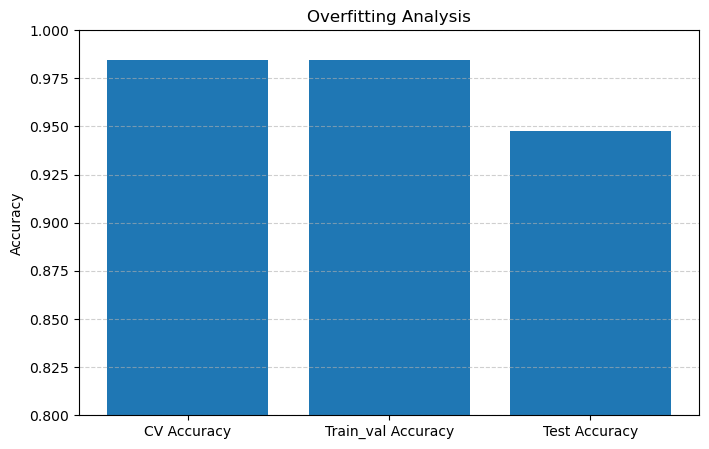

In [19]:
# --- Plot Overfitting ---
plt.figure(figsize=(8,5))
plt.bar(["CV Accuracy", "Train_val Accuracy", "Test Accuracy"],
        [acc_cv_best, acc_train_val, test_acc])
plt.title("Overfitting Analysis")
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show() 


In [20]:
# ------------------ 13. Summary table ------------------
summary = {
    "train_val_size": [len(train_val_df)],
    "test_size": [len(test_df)],
    "best_val_fit": [best_fit],
    "test_acc": [test_acc],
    "precision": [prec],
    "recall": [rec],
    "f1": [f1],
    "evals_used": [evals_used]
}
summary_df = pd.DataFrame(summary)
print("\nSummary:")
print(summary_df.to_string(index=False))


Summary:
 train_val_size  test_size  best_val_fit  test_acc  precision   recall       f1  evals_used
            455        114       0.98282  0.947368   0.928571 0.928571 0.928571        6000


In [21]:
# ----------------- 14) Prepare gbest_fitness_history -----------------
# history isi: list of tuples (iter, best_val_fit, evals)
if 'history' in globals() and len(history) > 0:
    gbest_fitness_history = [h[1] for h in history]  # fitness
    iter_list = [h[0] for h in history]               # iteration index
else:
    gbest_fitness_history = []
    iter_list = []

In [22]:
# ----------------- 15) Classification report (test) -----------------
# test_preds_binary sudah ada; test_y_binary juga
report_text = classification_report(test_y_binary, test_preds_binary, digits=4)
print("\n=== Classification Report (TEST SET) ===\n")
print(report_text)




=== Classification Report (TEST SET) ===

              precision    recall  f1-score   support

           0     0.9583    0.9583    0.9583        72
           1     0.9286    0.9286    0.9286        42

    accuracy                         0.9474       114
   macro avg     0.9435    0.9435    0.9435       114
weighted avg     0.9474    0.9474    0.9474       114



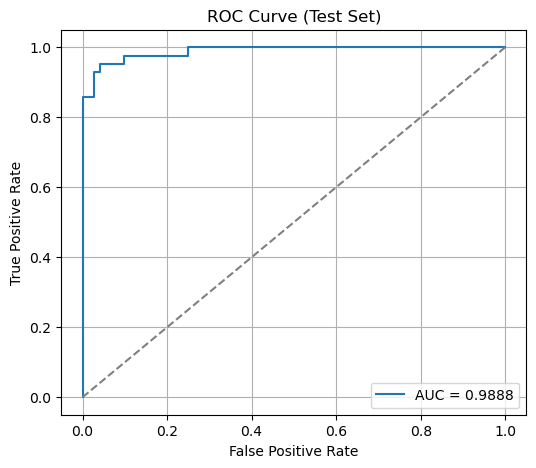

In [23]:
# ----------------- 16) ROC Curve & AUC -----------------
# Need decision scores (continuous) for ROC: use scores = w·x + b
scores_test = svm_scores_from_params(best_vec, X_test_std)

fpr, tpr, thresholds = roc_curve(test_y_binary, scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.close()


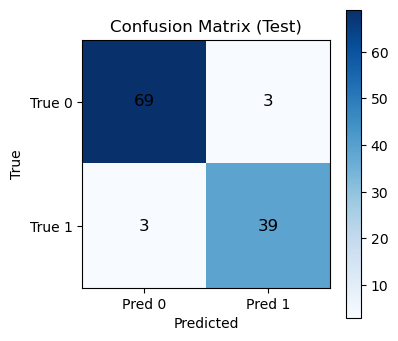

In [26]:
# ----------------- 17) Confusion matrix figure (heatmap) -----------------
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha='center', va='center', color='black', fontsize=12)

plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.close()

C:\Users\Elan\AppData\Local\Temp\ipykernel_26436\533093784.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_pca[~correct, 0], X_test_pca[~correct, 1],


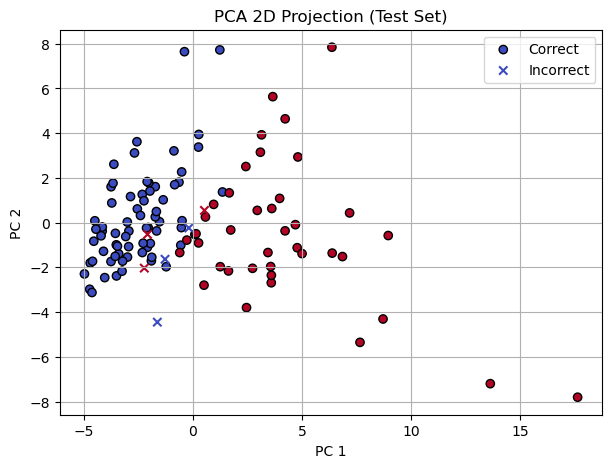

In [27]:
# ----------------- 18) PCA 2D visualisasi (test set) -----------------
# We'll reduce test set to 2D for plotting; color by true label and marker by correctness
pca = PCA(n_components=2)
pca.fit(X_train_val_std)
X_test_pca = pca.transform(X_test_std)

correct = (test_y_binary == test_preds_binary)

plt.figure(figsize=(7, 5))
plt.scatter(X_test_pca[correct, 0], X_test_pca[correct, 1],
            c=test_y_binary[correct],
            cmap='coolwarm', edgecolor='k', label="Correct", marker='o')

plt.scatter(X_test_pca[~correct, 0], X_test_pca[~correct, 1],
            c=test_y_binary[~correct],
            cmap='coolwarm', edgecolor='k', label="Incorrect", marker='x')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA 2D Projection (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.close()
